# Chapitre 8

In [2]:
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
datasets = pds.read_excel("dataset.xlsx")
datasets.corr()

,AMZN,BRENT,CAC40,NQ100,DJI30,DAX30,GOLD,EURUSD
AMZN,1.000000,-0.421819,0.778211,0.960369,0.950870,0.743347,-0.302171,-0.470636
BRENT,-0.421819,1.000000,-0.599353,-0.554603,-0.492757,-0.664231,0.652618,0.899293
CAC40,0.778211,-0.599353,1.000000,0.900011,0.898059,0.981916,-0.653307,-0.560685
NQ100,0.960369,-0.554603,0.900011,1.000000,0.989948,0.881750,-0.470683,-0.557515
DJI30,0.950870,-0.492757,0.898059,0.989948,1.000000,0.878014,-0.449811,-0.488816
DAX30,0.743347,-0.664231,0.981916,0.881750,0.878014,1.000000,-0.651545,-0.609943
GOLD,-0.302171,0.652618,-0.653307,-0.470683,-0.449811,-0.651545,1.000000,0.521115
EURUSD,-0.470636,0.899293,-0.560685,-0.557515,-0.488816,-0.609943,0.521115,1.000000


In [4]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]]
y = datasets[["NQ100"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1800-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1800,:].values

In [5]:
##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)

In [7]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(Xtrain_sc, ytrain_sc)
y_pred = sc.inverse_transform(lr.predict(Xvisu_sc))

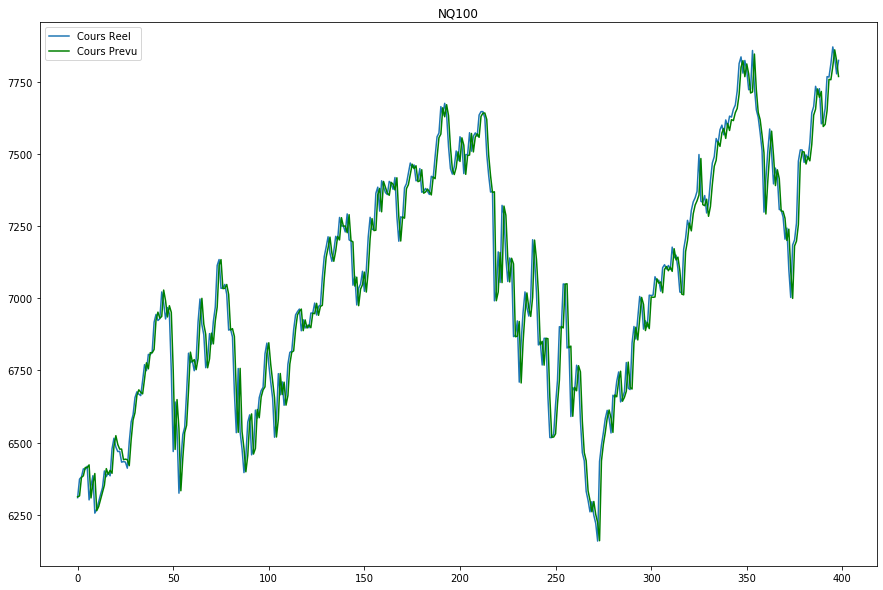

In [8]:
##### Affichage
plt.figure(figsize=(15,10))
plt.plot(y_visu, label="Cours Reel")
plt.plot(y_pred, color="green", label="Cours Prevu")
plt.legend()
plt.title("NQ100")
plt.show()

In [21]:
def pourcentage(y_pred, y_visu):
    tx_pred = pds.DataFrame(y_pred.reshape(len(y_pred),1)).pct_change(1).dropna().reset_index(drop=True).values
    tx_visu = pds.DataFrame(y_visu.reshape(len(y_visu),1)).pct_change(1).dropna().reset_index(drop=True).values

    
    return tx_pred, tx_visu

tx_pred, tx_visu = pourcentage(y_pred, y_visu)

In [58]:
def gain(tx_pred, tx_visu, sb=0.00, sh=0.00):
    # Initialisation
    l = len(tx_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    
    #Gain
    for i in range(l):
        if tx_pred[i][0]>sh:
            gain[i][0] = (tx_visu[i][0])
            hausse[i][0] = (tx_visu[i][0])
        if tx_pred[i][0]<-sb:
            gain[i][0] = (-tx_visu[i][0])
            baisse[i][0] = (-tx_visu[i][0])
    return gain

In [59]:
matrice = gain(tx_pred, tx_visu)

np.sum(matrice)

0.12882762305743778

In [76]:
# Fonction mesure des algorithmes de regression

def mesure_gain(tx_pred, tx_visu, sb=0.00, sh=0.00, spread=0.00050, levier=1):
    # Initialisation
    l = len(tx_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    count_true = 0
    count_false = 0
    p = 0
    
    #Gain
    for i in range(l):
        if tx_pred[i][0]>sh:
            gain[i][0] = (tx_visu[i][0]-spread)*levier
            hausse[i][0] = (tx_visu[i][0]-spread)*levier
        if tx_pred[i][0]<-sb:
            gain[i][0] = (-tx_visu[i][0]-spread)*levier
            baisse[i][0] = (-tx_visu[i][0]-spread)*levier
    
    # Affichage
    moyenne = np.mean(gain[gain!=0])
    ecart_type = np.std(gain[gain!=0])
    
    # Croissance
    coef = 1
    coef_ = np.zeros(l).reshape(l,1)

    for i in range(l):
        coef *= (1+gain[i][0])
        coef_[i][0] = coef
        
    pourcentage = (coef-1)*100
    
    
    sharpe = moyenne/ecart_type
    
    sortino = np.mean(gain[gain!=0])/np.std(gain[gain<0])
    
    #Mesures
    somme_gain_h = round(sum(hausse)[0]*100,2)
    somme_gain_b = round(sum(baisse)[0]*100,2)
    
    
    gain_max_hausse = round(np.max(hausse, axis=0)[0]*100,2)
    gain_min_hausse = round(np.min(hausse, axis=0)[0]*100,2)
    
    
    gain_max_baisse = round(np.max(baisse, axis=0)[0]*100,2)
    gain_min_baisse = round(np.min(baisse, axis=0)[0]*100,2)
    
    for i in range(l):
        if gain[i][0]>0:
            count_true += 1
        elif gain[i][0]<0:
            count_false += 1
    
    if count_false == 0 and count_true == 0:
        p="On ne peut pas calculer de probabilité"
    else:
        p = count_true/(count_false+count_true)
    
    # Affichage
    
    print("------------------ Données de bases -----------------------")
    print("Seuil_hausse:", sh)
    print("Seuil_baisse:", sb)
    print("Spread", spread)
    print("Effet de levier:",levier)
    print("                                                           ")
    print("---------------------- Mesures ----------------------------")
    print("Précision", round(p*100,2), "%")
    print("Pourcentage sur la période:", round(np.sum(gain)*100,2), "%")
    print("Poucentage composé:", round(pourcentage,2), "%")
    print("Ratio gain par trade:", round(moyenne*100,2), "%")
    print("Écart-type des gains:", round(ecart_type*100,2), "%")
    print("Ratio Sharpe:", round(sharpe,6))
    print("Ratio Sortino:", round(sortino,6))
    print("                                                           ")
    print("-------------------- Autres données -----------------------")
    print("Somme des gains à la hausse:", somme_gain_h, "%")
    print("Somme des gains à la baisse:", somme_gain_b, "%")
    print("gain max a la hausse:",gain_max_hausse, "%")
    print("gain min a la hausse:",gain_min_hausse, "%")
    print("gain max a la baisse:",gain_max_baisse, "%")
    print("gain min a la baisse:",gain_min_baisse, "%")
    print("                                                           ")
    print("-------------------- Distribution -----------------------")
    plt.title("Distribution gain")
    plt.hist(gain[gain!=0]*100,bins=55)
    plt.axvline(0, color="black")
    plt.xlabel("Pourcentage gain")
    plt.show()
    print("                                                           ")
    print("-------------------- Croissance -----------------------")
    plt.plot((coef_-1)*100,color="green")
    plt.title("Croissance Portefeuille")
    plt.ylabel("Gain(pourcentage)")
    plt.show()



On remarque que lorsque l'on a mis en place un spread la performance qui était déjà moyenne devient très médiocre et c'est pourquoi le modèle qui suit est entrainé avec les données en pourcentages.

##### Mesure gain pour le regression linéaire

In [62]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values*1000
X_visu = X.iloc[1400:1750-1,:].values*1000

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values




In [63]:
##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.54 %
Pourcentage sur la période: 29.63 %
Poucentage composé: 31.17 %
Ratio gain par trade: 0.08 %
Écart-type des gains: 1.19 %
Ratio Sharpe: 0.071091
Ratio Sortino: 0.103939
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 23.2 %
Somme des gains à la baisse: 6.42 %
gain max a la hausse: 4.43 %
gain min a la hausse: -4.17 %
gain max a la baisse: 5.1 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -----------------------


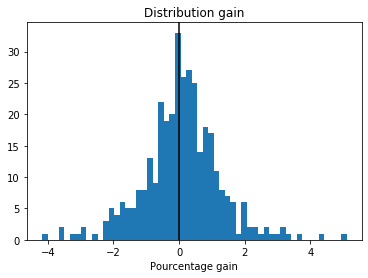

                                                           
-------------------- Croissance -----------------------


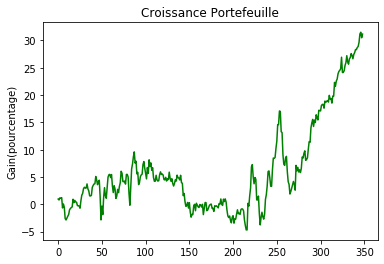

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.59 %
Pourcentage sur la période: 69.16 %
Poucentage composé: 94.82 %
Ratio gain par trade: 0.2 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.168551
Ratio Sortino: 0.243529
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 41.17 %
Somme des gains à la baisse: 27.99 %
gain max a la hausse: 4.43 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -----------------------


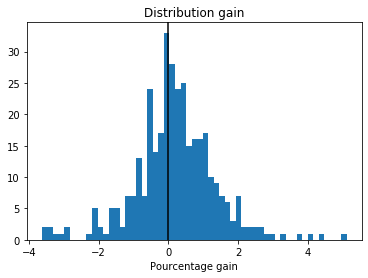

                                                           
-------------------- Croissance -----------------------


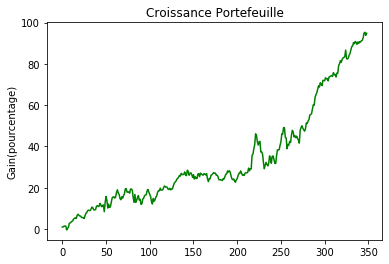

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.5 %
Pourcentage sur la période: 14.87 %
Poucentage composé: 13.16 %
Ratio gain par trade: 0.04 %
Écart-type des gains: 1.2 %
Ratio Sharpe: 0.03556
Ratio Sortino: 0.053622
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 17.88 %
Somme des gains à la baisse: -3.01 %
gain max a la hausse: 4.43 %
gain min a la hausse: -5.2 %
gain max a la baisse: 4.07 %
gain min a la baisse: -2.7 %
                                                           
-------------------- Distribution -----------------------


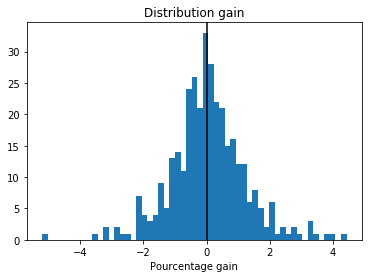

                                                           
-------------------- Croissance -----------------------


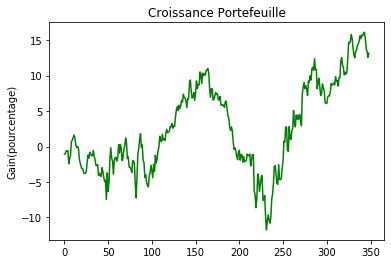

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.52 %
Pourcentage sur la période: 22.03 %
Poucentage composé: 21.57 %
Ratio gain par trade: 0.06 %
Écart-type des gains: 1.2 %
Ratio Sharpe: 0.052768
Ratio Sortino: 0.078932
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 21.71 %
Somme des gains à la baisse: 0.32 %
gain max a la hausse: 4.43 %
gain min a la hausse: -4.17 %
gain max a la baisse: 5.1 %
gain min a la baisse: -3.45 %
                                                           
-------------------- Distribution -----------------------


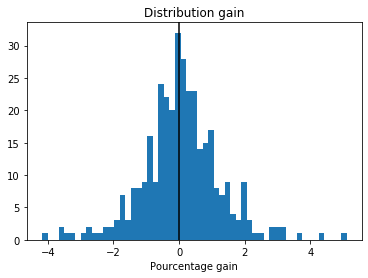

                                                           
-------------------- Croissance -----------------------


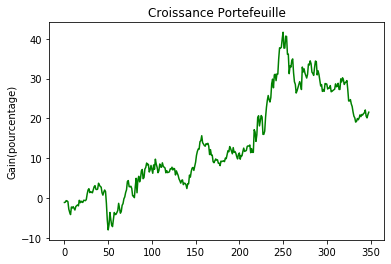

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.56 %
Pourcentage sur la période: 49.24 %
Poucentage composé: 59.61 %
Ratio gain par trade: 0.14 %
Écart-type des gains: 1.19 %
Ratio Sharpe: 0.118934
Ratio Sortino: 0.1764
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 32.91 %
Somme des gains à la baisse: 16.33 %
gain max a la hausse: 3.73 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -4.53 %
                                                           
-------------------- Distribution -----------------------


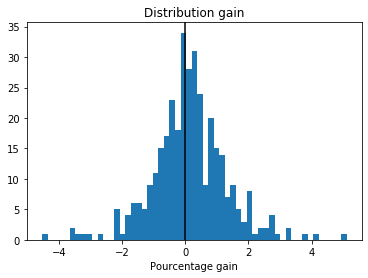

                                                           
-------------------- Croissance -----------------------


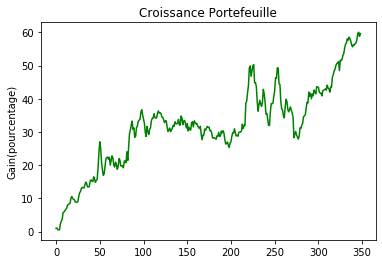

In [64]:
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

regresseur = [SVR(max_iter=1000000), LinearSVR(max_iter=1000000),
             RandomForestRegressor(), DecisionTreeRegressor(),
             LinearRegression()]


for rl in regresseur:

    rl.fit(Xtrain_sc, ytrain_sc)
    y_pred = sc.inverse_transform(rl.predict(Xvisu_sc))

    y_pred = y_pred.reshape(len(y_pred),1)
    
    mesure_gain(y_pred, y_visu)

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 55.59 %
Pourcentage sur la période: 49.24 %
Poucentage composé: 59.61 %
Ratio gain par trade: 0.14 %
Écart-type des gains: 1.19 %
Ratio Sharpe: 0.118934
Ratio Sortino: 0.1764
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 32.91 %
Somme des gains à la baisse: 16.33 %
gain max a la hausse: 3.73 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -4.53 %
                                                           
-------------------- Distribution -----------------------


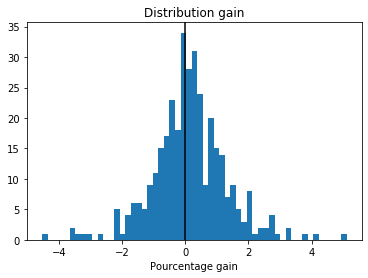

                                                           
-------------------- Croissance -----------------------


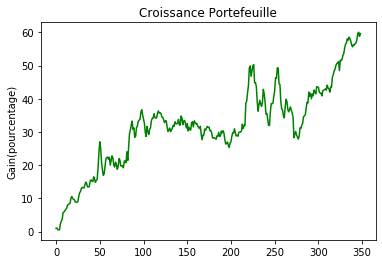

In [77]:
mesure_gain(y_pred, y_visu)

##### Fonction mesure des gains pour classificateur

In [3]:
datasets = pds.read_excel("dataset.xlsx", index_col="Date", parse_dates=True)
datasets_pct = datasets.pct_change(1).dropna().reset_index(drop=True)
datasets_pct["Étiquetage"] = round(datasets_pct["NQ100"]+0.5)
datasets_pct



In [41]:
##### Scindage de la base de données en X et y
X = datasets_pct[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]]
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1700-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1700,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

lr.fit(Xtrain_sc, y_train)
y_pred = lr.predict(Xvisu_sc)
accuracy_score(y_visu, y_pred)

0.5953177257525084

In [57]:
##### Fonction gain pour les classificateurs
def mesure_classifieur(y_pred, tx_visu, spread=0.00050, levier=1):
    # Initialisation
    l = len(y_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    
    y_pred = y_pred.reshape(len(y_pred),1)
    count_true = 0
    count_false = 0
    p = 0
    
    #Gain
    for i in range(l):
        if y_pred[i][0]==1:
            gain[i][0] = (tx_visu[i][0]-spread)*levier
            hausse[i][0] = (tx_visu[i][0]-spread)*levier
        if y_pred[i][0]==0:
            gain[i][0] = (-tx_visu[i][0]-spread)*levier
            baisse[i][0] = (-tx_visu[i][0]-spread)*levier
    
    # Affichage
    moyenne = np.mean(gain[gain!=0])
    ecart_type = np.std(gain[gain!=0])
    
    # Croissance
    coef = 1
    coef_ = np.zeros(l).reshape(l,1)

    for i in range(l):
        coef *= (1+gain[i][0])
        coef_[i][0] = coef
        
    pourcentage = (coef-1)*100
    
    
    sharpe = moyenne/ecart_type
    
    sortino = np.mean(gain[gain!=0])/np.std(gain[gain<0])
    
    #Mesures
    somme_gain_h = round(sum(hausse)[0]*100,2)
    somme_gain_b = round(sum(baisse)[0]*100,2)
    
    
    gain_max_hausse = round(np.max(hausse, axis=0)[0]*100,2)
    gain_min_hausse = round(np.min(hausse, axis=0)[0]*100,2)
    
    
    gain_max_baisse = round(np.max(baisse, axis=0)[0]*100,2)
    gain_min_baisse = round(np.min(baisse, axis=0)[0]*100,2)
    
    for i in range(l):
        if gain[i][0]>0:
            count_true += 1
        elif gain[i][0]<0:
            count_false += 1
    
    if count_false == 0 and count_true == 0:
        p="On ne peut pas calculer de probabilité"
    else:
        p = count_true/(count_false+count_true)
    
    
    print("------------------ Données de bases -----------------------")
    print("Spread", spread)
    print("Effet de levier:",levier)
    print("                                                           ")
    print("---------------------- Mesures ----------------------------")
    print("Précision", round(p,2), "%")
    print("Pourcentage sur la période:", round(np.sum(gain)*100,2), "%")
    print("Poucentage composé:", round(pourcentage,2), "%")
    print("Ratio gain par trade:", round(moyenne*100,2), "%")
    print("Écart-type des gains:", round(ecart_type*100,2), "%")
    print("Ratio Sharpe:", round(sharpe,6))
    print("Ratio Sortino:", round(sortino,6))
    print("                                                           ")
    print("-------------------- Autres données -----------------------")
    print("Somme des gains à la hausse:", somme_gain_h, "%")
    print("Somme des gains à la baisse:", somme_gain_b, "%")
    print("gain max a la hausse:",gain_max_hausse, "%")
    print("gain min a la hausse:",gain_min_hausse, "%")
    print("gain max a la baisse:",gain_max_baisse, "%")
    print("gain min a la baisse:",gain_min_baisse, "%")
    print("                                                           ")
    print("-------------------- Distribution -----------------------")
    plt.title("Distribution gain")
    plt.hist(gain[gain!=0]*100,bins=55)
    plt.axvline(0, color="black")
    plt.xlabel("Pourcentage gain")
    plt.show()
    print("                                                           ")
    print("-------------------- Croissance -----------------------")
    plt.plot((coef_-1)*100,color="green")
    plt.title("Croissance Portefeuille")
    plt.ylabel("Gain(pourcentage)")
    plt.show()



------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Précision 0.57 %
Pourcentage sur la période: 46.21 %
Poucentage composé: 55.07 %
Ratio gain par trade: 0.15 %
Écart-type des gains: 1.24 %
Ratio Sharpe: 0.124189
Ratio Sortino: 0.182113
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 24.54 %
Somme des gains à la baisse: 21.67 %
gain max a la hausse: 4.43 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -----------------------


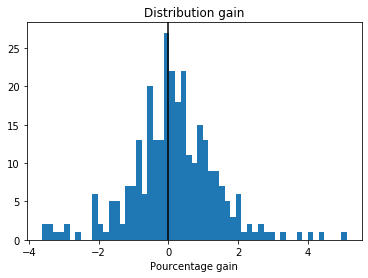

                                                           
-------------------- Croissance -----------------------


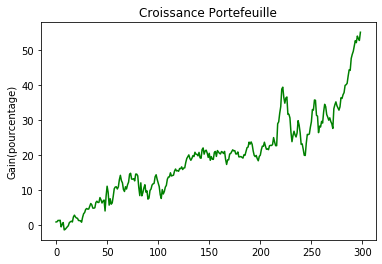

In [58]:
tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1700,:].values

mesure_classifieur(y_pred, tx_visu)